In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import NamedTuple
import pytz
import io
import os
plt.rcParams["figure.figsize"] = (10, 7)
import requests
import duckdb

import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [ ]:
def _get_auth(env_var: str = "SELF"):
    return tuple(os.environ[env_var].split(":"))

AUTH = _get_auth()
def _get_dfm(url, auth=AUTH):
# def _get_dfm(url):
    resp = requests.get(url, auth=auth)
    
    if resp.status_code != 200:
        print(resp.text)
        resp.raise_for_status()
        
    dfm = pd.read_csv(
        io.StringIO(
            resp.text
        )
    )
    
    return dfm

In [6]:
# Run this with the proper task name
# TASK_UID=31ceeb4f-c01c-4e76-a717-291425624c23; for report in load bus generator branch; do mkdir -p $TASK_UID/$report; gsutil -m cp "gs://marginalunit-placebo/runs/20240311t1950z/canonical-topology/$report/$TASK_UID*" $TASK_UID/$report; done

In [7]:
!ls /Users/michael.simantov/Documents/draft/run-export

31ceeb4f-c01c-4e76-a717-291425624c23


In [8]:
!ls /Users/michael.simantov/Documents/draft/run-export/31ceeb4f-c01c-4e76-a717-291425624c23

branch    bus       generator load


In [9]:
root = "/Users/michael.simantov/Documents/draft/run-export"
task_uid = "31ceeb4f-c01c-4e76-a717-291425624c23"
path = f"{root}/{task_uid}"

In [10]:
bus_t =  duckdb.sql(
    f"""
    SELECT *, string_split(filename, '/')[-1] AS scenario_hour
    FROM READ_PARQUET("{path}/bus/*.parquet", filename=true)
    """
)

# branch_t =  duckdb.sql(
#     f"""
#     SELECT *, string_split(filename, '/')[-1] AS scenario_hour
#     FROM READ_PARQUET("{path}/branch/*.parquet", filename=true)
#     """
# )


generator_t =  duckdb.sql(
    f"""
    SELECT *, string_split(filename, '/')[-1] AS scenario_hour
    FROM READ_PARQUET("{path}/generator/*.parquet", filename=true)
    """
)

load_t =  duckdb.sql(
    f"""
    SELECT *, string_split(filename, '/')[-1] AS scenario_hour
    FROM READ_PARQUET("{path}/load/*.parquet", filename=true)
    """
)

In [11]:
db = duckdb.sql(
    """
    SELECT bus_t.scenario_hour, uid, bus_t.name, pl, pg,  FROM bus_t
    LEFT JOIN (
        SELECT bus_id, scenario_hour, SUM(pl) as pl FROM load_t GROUP BY bus_id, scenario_hour
    ) ld
    ON bus_t.id = ld.bus_id AND bus_t.scenario_hour = ld.scenario_hour
    LEFT JOIN (
        SELECT bus_id, scenario_hour, SUM(pg) as pg FROM generator_t GROUP BY bus_id, scenario_hour
    ) g
    ON bus_t.id = g.bus_id AND bus_t.scenario_hour = g.scenario_hour
    """
)

In [12]:
dfm = db.to_df()
dfm["timestamp"] = pd.to_datetime(
    dfm.scenario_hour.map(lambda v: v.split("--")[-1].split(".")[0])
).dt.tz_convert("US/Central")

In [13]:
dfm

,scenario_hour,uid,name,pl,pg,timestamp
0,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,FORMOSA_13KV_2,FORMOSA,0.0,0.000000,2024-02-24 06:00:00-06:00
1,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,PR_13KV_1,PR,0.0,0.000000,2024-02-24 06:00:00-06:00
2,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,BTE_18KV_2,BTE,0.0,0.000000,2024-02-24 06:00:00-06:00
3,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,CVC_18KV_3,CVC,0.0,572.075879,2024-02-24 06:00:00-06:00
4,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,THW_13KV_1,THW,0.0,0.000000,2024-02-24 06:00:00-06:00
...,...,...,...,...,...,...
1343623,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,WIRTZ_13KV_2,WIRTZ,0.0,0.000000,2024-02-29 22:00:00-06:00
1343624,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,BASTEN_18KV_3,BASTEN,0.0,487.209395,2024-02-29 22:00:00-06:00
1343625,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,PEARSAL2_13KV_1,PEARSAL2,0.0,0.000000,2024-02-29 22:00:00-06:00
1343626,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,FALCON_6KV_2,FALCON,0.0,0.000000,2024-02-25 09:00:00-06:00


In [14]:
CASE_CODE = "ercot_rt_se_20231023_H17"
COLLECTION = "ercot-rt-se.dev"

df_branches = _get_dfm(f"https://api1.marginalunit.com/reflow/{COLLECTION}/{CASE_CODE}/branches")  # fetch branches
df_mapping_logical = _get_dfm(f"https://api1.marginalunit.com/rms/ercot/grouped-constraints/{COLLECTION}/monitored-branch-mappings")
df_contingencies = _get_dfm(f"https://api1.marginalunit.com/reflow/{COLLECTION}/{CASE_CODE}/contingencies")

In [15]:
# MONITORED_UID = "6036__A,TKWSW,345.0,MGSES,345.0"
# CONTINGENCY_UID = "SMDOPHR5"
CONTINGENCY_UID = "SOZNFRI9"

# monitored = df_mapping_logical[df_mapping_logical.monitored_uid == MONITORED_UID].iloc[0].branch_uid
# monitored = "138_ALV_NAL_1"
monitored = "BIGLAK_PHBL_T1_1"

contingency_branches = list(df_contingencies[df_contingencies.contingency_name == CONTINGENCY_UID].branch_name)
contingency_branches

['FRIEND_OZONA1_1']

In [16]:
dfb_reflow = _get_dfm(f"https://api1.marginalunit.com/reflow/{COLLECTION}/{CASE_CODE}/buses?columns=memo,name,pg,pl")
df_sf_reflow = _get_dfm(
    f"https://api1.marginalunit.com/reflow/{COLLECTION}/{CASE_CODE}/constraint_exposure/buses?monitored={monitored}&outaged={','.join(contingency_branches)}"
)

In [17]:
# Check it works:
# f"https://api1.marginalunit.com/reflow/{COLLECTION}/{CASE_CODE}/constraint_exposure/buses?monitored={monitored}&outaged={','.join(contingency_branches)}"

In [18]:
dfm.timestamp.agg(['min', 'max'])

min   2024-02-24 00:00:00-06:00
max   2024-02-29 23:00:00-06:00
Name: timestamp, dtype: datetime64[ns, US/Central]

In [19]:
# SELECTED_DATETIME = "2023-10-23 16:00:00-05:00"
SELECTED_DATETIME = "2024-02-27 08:00:00-06:00"  # works!

In [20]:
# make sure data exist
dfm[dfm.timestamp == SELECTED_DATETIME]

,scenario_hour,uid,name,pl,pg,timestamp
1163946,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,TC_13KV_1,TC,0.000000,37.000000,2024-02-27 08:00:00-06:00
1163947,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,PR_13KV_1,PR,0.000000,0.000000,2024-02-27 08:00:00-06:00
1163948,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,BTE_18KV_2,BTE,0.000000,0.000000,2024-02-27 08:00:00-06:00
1163949,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,CVC_18KV_3,CVC,0.000000,572.075879,2024-02-27 08:00:00-06:00
1163950,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,THW_13KV_1,THW,0.000000,0.000000,2024-02-27 08:00:00-06:00
...,...,...,...,...,...,...
1230306,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,RINGGOLD_69KV_1,RINGGOLD,8.681969,NaN,2024-02-27 08:00:00-06:00
1230307,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,NOVA1SLR_34KV_2,NOVA1SLR,0.000000,NaN,2024-02-27 08:00:00-06:00
1230855,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,THW_13KV_3,THW,0.000000,0.000000,2024-02-27 08:00:00-06:00
1230856,31ceeb4f-c01c-4e76-a717-291425624c23 -- 2024-0...,JAY_34KV_2,JAY,0.000000,53.414089,2024-02-27 08:00:00-06:00


In [21]:
dff = pd.merge(
    dfm[dfm.timestamp == SELECTED_DATETIME].set_index("uid", verify_integrity=True)[["name", "pg", "pl"]],
    dfb_reflow.set_index("memo")[["pg", "pl"]],
    left_index=True,
    right_index=True,
    suffixes=("_p", "_r")
).fillna(0)

dff["net_inj_p"] = dff.pg_p - dff.pl_p
dff["net_inj_r"] = dff.pg_r - dff.pl_r

dff = pd.merge(
    dff,
    df_sf_reflow.set_index("bus_memo")[["exposure"]],
    left_index=True,
    right_index=True
)

dff["impact_p"] = dff.net_inj_p * dff.exposure
dff["impact_r"] = dff.net_inj_r * dff.exposure
dff["impact_diff"] = dff.impact_p - dff.impact_r

/Users/michael.simantov/anaconda3/envs/Michael_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'Impact diff between Reflow and P&RF for 2024-02-27 08:00:00-06:00')

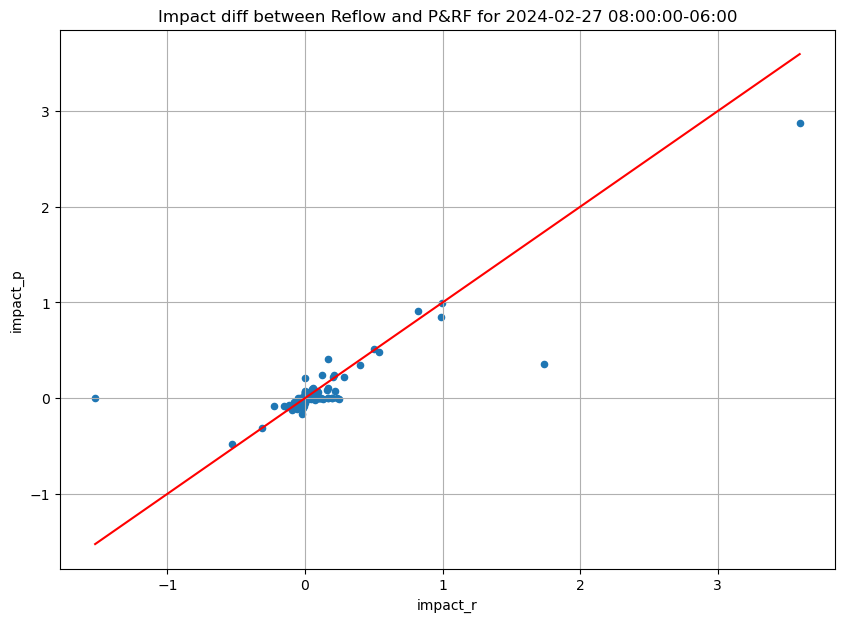

In [22]:
agg_fn =  {
    c: "sum"
    for c in dff.columns
    if c != "name"
}
agg_fn["exposure"] = "mean"


dffa = dff.groupby("name").agg(agg_fn)
dffa["abs_impact_diff"] = abs(dffa.impact_p - dffa.impact_r)

dffa.plot(
    kind="scatter",
    x="impact_r",
    y="impact_p",
    grid=True
)

x = np.linspace(
    dffa.impact_r.min(),
    dffa.impact_r.max()
)

plt.plot(x, x, color="red")

plt.title(f"Impact diff between Reflow and P&RF for {SELECTED_DATETIME}")

In [338]:
dffa.impact_diff.sum()

-1.3709040595276254

In [339]:
-dffa.impact_r.sum()

-6.163172989999999

In [340]:
-dffa.impact_p.sum()

-4.792268930472374

In [341]:
dffa.sort_values("impact_diff", ascending=False).head(10)

,pg_p,pl_p,pg_r,pl_r,net_inj_p,net_inj_r,exposure,impact_p,impact_r,impact_diff,abs_impact_diff
name,,,,,,,,,,,
APPALOSA,0.000000,0.000000,161.757,0.000,0.000000,161.757,-0.009430,0.000000,-1.525369,1.525369,1.525369
LGD,136.212800,0.000000,54.336,0.000,136.212800,54.336,0.003020,0.411363,0.164095,0.247268,0.247268
PHBL,0.000000,0.305379,0.000,0.000,-0.305379,0.000,-0.703960,0.214975,0.000000,0.214975,0.214975
OECCS,307.300156,0.000000,798.858,0.000,307.300156,798.858,-0.000280,-0.086044,-0.223680,0.137636,0.137636
CPSES,2465.700000,0.000000,1201.595,1.370,2465.700000,1200.225,0.000105,0.246570,0.119995,0.126575,0.126575
STRS,0.000000,1.425104,0.000,1.290,-1.425104,-1.290,-0.639230,0.910969,0.824607,0.086363,0.086363
MCSES,722.508132,0.000000,0.000,0.000,722.508132,0.000,0.000110,0.079476,0.000000,0.079476,0.079476
CTZ,0.000000,436.800000,0.000,842.747,-436.800000,-842.747,0.000180,-0.078624,-0.151694,0.073070,0.073070
NUECES_B,257.689299,0.000000,0.000,0.000,257.689299,0.000,0.000240,0.061845,0.000000,0.061845,0.061845


<AxesSubplot: xlabel='timestamp'>

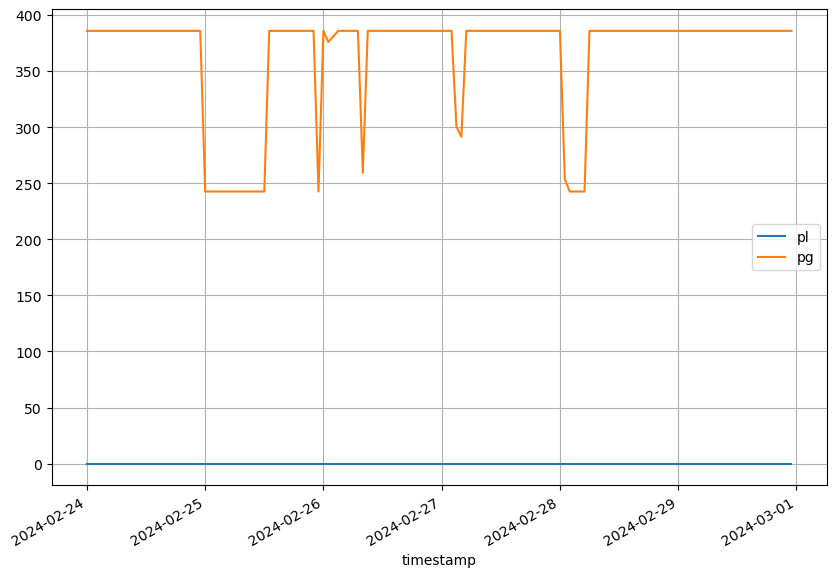

In [342]:
dfm[dfm.name == "AMOCOOIL"].groupby("timestamp").sum()[["pl", "pg"]].plot(grid=True)